# Часть 1. Парсинг

1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
import requests, json
import time
import os
import requests  
from bs4 import BeautifulSoup 
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt

2. Первый взгляд на готовый тестовый датасет

In [2]:
DIR_TEST = '../input/sf-dst-car-price/'
OUTPUT_DIR = '../output/'

In [3]:
data_test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [4]:
data_test.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,В РОЛЬФ Ясенево представлено более 500 автомоб...,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,0
1,седан,BMW,белый,дизель,2018.0,318d 2.0d AT (150 л.с.),4.0,2019.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,150 N12,Автомобиль из демонстрационного парка по спец ...,10.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,1
2,седан,BMW,синий,бензин,2009.0,550i xDrive 4.4 AT (407 л.с.) 4WD,4.0,2012.0,SEDAN AUTOMATIC 4.4,автоматическая,4.4 LTR,407 N12,Машина собиралась под заказ! \n\n,120000.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,7 лет и 2 месяца,2
3,внедорожник 5 дв.,BMW,белый,дизель,2014.0,30d 3.0d AT (249 л.с.) 4WD,5.0,2015.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,249 N12,АВТОМОБИЛЬ В БЕЗУПРЕЧНОМ ВНЕШНЕМ И ТЕХНИЧЕСКОМ...,111466.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,NaN,3
4,внедорожник 5 дв.,BMW,синий,дизель,2014.0,M50d 3.0d AT (381 л.с.) 4WD,5.0,2019.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,381 N12,Автомобиль не имеет собственников ( физ. лиц) ...,11891.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,4


In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3837 entries, 0 to 3836
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              3837 non-null   object 
 1   brand                 3837 non-null   object 
 2   color                 3837 non-null   object 
 3   fuelType              3837 non-null   object 
 4   modelDate             3837 non-null   float64
 5   name                  3837 non-null   object 
 6   numberOfDoors         3837 non-null   float64
 7   productionDate        3837 non-null   float64
 8   vehicleConfiguration  3837 non-null   object 
 9   vehicleTransmission   3837 non-null   object 
 10  engineDisplacement    3837 non-null   object 
 11  enginePower           3837 non-null   object 
 12  description           3837 non-null   object 
 13  mileage               3837 non-null   float64
 14  Комплектация          3837 non-null   object 
 15  Привод               

Видно что во всех столбцах кроме "Владение" данные представлены полностью. Оставим анализ и обработку этих данных для следующего этапа, а пока возьмём названия всех колонок, для того чтобы понимать какие данные будем парсить.

In [6]:
data_test.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'id'],
      dtype='object')

In [7]:
columns_name_dict = {}
for i in data_test.columns:
    columns_name_dict[i] = 0

3. Подготовка к парсингу данных

In [8]:
import requests  
from bs4 import BeautifulSoup 

In [9]:
# Сделаем тестовый запрос чтобы посмотреть какие данные приходят и проанализировать как в дальнейшем их обрабатывать

URL = 'https://auto.ru/-/ajax/desktop/listing/' #URL на который будет отправлен запрос

mark = 'HONDA'  # марка
model = 'ACCORD'  # модель
geo_radius = 200  # радиус вокруг москвы = 200 км
geo_id = [213]  # Москва
top_days = "1"  # кол-во дней от текущей даты назад за которые запрашиваем объявления 

param = {
                'catalog_filter' : [{"mark": mark, "model": model}],
                'section': "all",
                'category': "cars",
                'sort': "fresh_relevance_1-desc",
                "top_days":top_days,
                "geo_radius":geo_radius,
                "geo_id":geo_id,
                'page': 1
            }

HEADERS = {
        'Accept': '*/*',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3',
        'Connection': 'keep-alive',
        'Content-Length': '1',
        'content-type': 'application/json',
        'Cookie': '_csrf_token=df8af3435de0ea5dd1a651b8e7bde1b6fd5e57945e0b0c6c; autoru_sid=a%3Ag5fbb74172s09isaetrjhu8dm1u2i34n.e5e6d790aa018577bf6fe2204db99922%7C1606399360788.604800.iJDFaWTnL3xaBCbH6Hq12g.Ez-LtkuYJIEQRqZQHbk_cZIb7VqnmqvL4xuTrMVd8Ks; autoruuid=g5fbb74172s09isaetrjhu8dm1u2i34n.e5e6d790aa018577bf6fe2204db99922; suid=25f62e6da872ddff530e9708562c27e5.dcedbe7f9ffbd4bbaae4ab58654037f4; from_lifetime=1606400400961; from=direct; X-Vertis-DC=myt; crookie=H+q+QeAJ+vTboOrv6vXvSnjly5j/a0TsuShfkPV9bL0hHQw0GWMdFTJBYUyIkX86W280FlyhX4uJGYhFkYgOXDvtY5M=; cmtchd=MTYwNjM5MDMwMDYzMw==; yandexuid=9774671561572616848; bltsr=1; navigation_promo_seen-recalls=true; autoru_gdpr=1',
        'Host': 'auto.ru',
        'origin': 'https://auto.ru',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:72.0) Gecko/20100101 Firefox/72.0',
        'x-csrf-token': 'df8af3435de0ea5dd1a651b8e7bde1b6fd5e57945e0b0c6c'
    }

response = requests.post(URL, json=param, headers=HEADERS) #Делаем post запрос на url
data = response.json()
for elem in data['offers']:
    print(elem)
    break

{'availability': 'IN_STOCK', 'category': 'cars', 'color_hex': 'CACECB', 'delivery_info': {}, 'description': 'Машина в идеальном состоянии!!!\nПокупалась в 2009 году\nЗа всё время не было ни одного Дтп! (Даже мелких)\nНовая Резина Pirelli\nПротивоугонная система\nВсе вопросы по телефону', 'discount_options': {}, 'documents': {'owners_number': 2, 'pts_original': True, 'custom_cleared': True, 'year': 2008, 'vin': 'JHM**************', 'pts': 'ORIGINAL', 'license_plate': '******|47', 'vin_resolution': 'OK'}, 'is_favorite': False, 'old_category_id': 15, 'owner_expenses': {'transport_tax': {'tax_by_year': 7020, 'year': 2020, 'rid': 213, 'rate': 45, 'horse_power': 156, 'holding_period_month': 12, 'boost': 1}, 'osago_insurance': [{'insurance_company': 'TINKOFF', 'price': 6309}]}, 'section': 'used', 'seller_type': 'PRIVATE', 'services': [{'service': 'all_sale_special', 'is_active': True, 'prolongable': False}, {'service': 'all_sale_color', 'is_active': True, 'prolongable': False}, {'service': 'a

In [10]:
def utils_clean_values_dict(d_dict):
    for elem in d_dict:
        d_dict[elem] = 0
    return

In [11]:
# создаем функцию для обработки 23 необходимых столбцов из объявления в словарь
def from_elem_to_dict(d_elem, d_dict):
    utils_clean_values_dict(d_dict)
    
    try: d_dict['bodyType'] = d_elem['vehicle_info']['configuration']['human_name']
    except: d_dict['bodyType'] = None

    try: d_dict['brand'] = d_elem['vehicle_info']['mark_info']['code']
    except: d_dict['brand'] = None

    try: d_dict['color'] = d_elem['color_hex']
    except: d_dict['color'] = None

    try: d_dict['fuelType'] = d_elem['lk_summary'].split()[-1]
    except: d_dict['fuelType'] = None

    try: d_dict['modelDate'] = d_elem['vehicle_info']['super_gen']['year_from']
    except: d_dict['modelDate'] = None

    try: d_dict['name'] =  d_elem['vehicle_info']['tech_param']['human_name']
    except: d_dict['name'] = None

    try: d_dict['numberOfDoors'] = d_elem['vehicle_info']['configuration']['doors_count']
    except: d_dict['numberOfDoors'] = None

    try: d_dict['productionDate'] = d_elem['documents']['year']
    except: d_dict['productionDate'] = None

    try: d_dict['vehicleTransmission'] = d_elem['vehicle_info']['tech_param']['transmission']
    except: d_dict['vehicleTransmission'] = None

    try: d_dict['engineDisplacement'] = d_elem['vehicle_info']['tech_param']['human_name'].split()[0]
    except: d_dict['engineDisplacement'] = None

    try: d_dict['vehicleConfiguration'] = elem['vehicle_info']['configuration']['body_type']+' '+d_dict['vehicleTransmission']+' '+d_dict['engineDisplacement']
    except: d_dict['vehicleConfiguration'] = None

    try: d_dict['enginePower'] = d_elem['vehicle_info']['tech_param']['power']
    except: d_dict['enginePower'] = None

    try: d_dict['description'] = d_elem['description']
    except: d_dict['description'] = None

    try: d_dict['mileage'] = d_elem['state']['mileage']
    except: d_dict['mileage'] = None

    try: d_dict['Комплектация'] = d_elem['vehicle_info']['complectation']
    except: d_dict['Комплектация'] = None

    try: d_dict['Привод'] = d_elem['lk_summary'].split(', ')[-2]
    except: d_dict['Привод'] = None
        
    try: d_dict['Руль'] = d_elem['vehicle_info']['steering_wheel']
    except: d_dict['Руль'] = None

    # 'Состояние' не найдено во время парсинга страниц
    d_dict['Состояние'] = None

    try: d_dict['Владельцы'] = d_elem['documents']['owners_number']
    except: d_dict['Владельцы'] = None

    try: d_dict['ПТС'] = d_elem['documents']['pts']
    except: d_dict['ПТС'] = None

    try: d_dict['Таможня'] = d_elem['documents']['custom_cleared']
    except: d_dict['Таможня'] = None

    try: d_dict['Владение'] =  d_elem['documents']['purchase_date']
    except: d_dict['Владение'] = None


    try: d_dict['price'] = d_elem['price_info']['RUR']
    except: d_dict['price'] = None
        
    # модель 
    d_dict['model'] =  model

    return

Вручную получим данные о количестве автомобилей каждой марки в продаже на текущий день(26-11-2020)

In [12]:
dict_carmodel_carcount = {'AC': 5, 'AMC': 2, 'Acura': 177, 'Adler': 3, 'Alfa Romeo': 186, 'Alpina': 10, 'Apal': 1,
                          'Ariel': 2, 'Aro': 6, 'Asia': 10, 'Aston Martin': 26, 'Audi': 11367, 'Austin': 2, 'Austin Healey': 1,
                          'BMW': 15666, 'BYD': 295, 'Bentley': 181, 'Borgward': 1, 'Brilliance': 135, 'Bugatti': 1, 'Buick': 41,
                          'CHERYEXEED': 45, 'Cadillac': 856, 'ChangFeng': 2, 'Changan': 530, 'Changhe': 2, 'Chery': 3820,
                          'Chevrolet': 16639, 'Chrysler': 782, 'Citroen': 2922, 'DKW': 3, 'DS': 3, 'DW Hower': 22, 'Dacia': 46,
                          'Dadi': 4, 'Daewoo': 5575, 'Daihatsu': 478, 'Daimler': 4, 'Datsun': 1828, 'Delage': 1, 'Derways': 26,
                          'Dodge': 1009, 'DongFeng': 75, 'Doninvest': 19, 'Eagle': 5, 'Excalibur': 1, 'FAW': 344, 'FSO': 1,
                          'Ferrari': 28, 'Fiat': 1145, 'Ford': 15053, 'Foton': 17, 'GAC': 32, 'GMC': 57, 'Geely': 2450,
                          'Genesis': 86, 'Geo': 4, 'Great Wall': 1318, 'Hafei': 58, 'Haima': 100, 'Haval': 774, 'Hawtai': 15,
                          'Heinkel': 1, 'Honda': 6461, 'HuangHai': 6, 'Hummer': 178, 'Hyundai': 22120, 'Infiniti': 2001,
                          'Iran Khodro': 87, 'Isuzu': 182, 'JAC': 64, 'JMC': 1, 'Jaguar': 871, 'Jeep': 1025, 'Jinbei': 8,
                          'Kia': 18919, 'LADA (ВАЗ)': 83264, 'Lamborghini': 14, 'Lancia': 38, 'Land Rover': 4039, 'Landwind': 3,
                          'Lexus': 3328, 'Lifan': 2907, 'Lincoln': 205, 'Luxgen': 28, 'MG': 14, 'MINI': 668, 'Mahindra': 2,
                          'Marussia': 1, 'Maruti': 1, 'Maserati': 82, 'Maybach': 11, 'Mazda': 9327, 'McLaren': 6, 'Mercedes-Benz': 22051,
                          'Mercury': 45, 'Metrocab': 2, 'Mitsubishi': 12610, 'Mitsuoka': 2, 'Nissan': 20950, 'Oldsmobile': 10,
                          'Opel': 11490, 'PUCH': 9, 'Packard': 2, 'Peugeot': 5640, 'Plymouth': 47, 'Pontiac': 128, 'Porsche': 1576,
                          'Proton': 16, 'RAM': 10, 'Ravon': 325, 'Renault': 16113, 'Renault Samsung': 2, 'Rolls-Royce': 83,
                          'Rover': 280, 'SEAT': 243, 'Saab': 344, 'Santana': 1, 'Saturn': 43, 'Scion': 22, 'Shanghai Maple': 9,
                          'ShuangHuan': 4, 'Simca': 1, 'Skoda': 9079, 'Smart': 163, 'SsangYong': 2193, 'Subaru': 3050, 'Suzuki': 3431,
                          'TATA': 3, 'Tatra': 3, 'Tesla': 86, 'Tianma': 3, 'Tianye': 12, 'Toyota': 24550, 'Trabant': 6,
                          'Triumph': 4, 'Vauxhall': 2, 'Volkswagen': 20369, 'Volvo': 3857, 'Vortex': 504, 'Wanderer': 5,
                          'Wartburg': 3, 'Willys': 14, 'Xin Kai': 3, 'Xpeng': 1, 'ZX': 27, 'Zotye': 99, 'Автокам': 1,
                          'ГАЗ': 5004, 'Гоночный болид': 3, 'ЗАЗ': 1618, 'ЗИЛ': 8, 'ЗиС': 2, 'ИЖ': 730, 'ЛуАЗ': 315, 'Москвич': 775,
                          'СМЗ': 20, 'ТагАЗ': 282, 'УАЗ': 6071}

Проанализировав количество автомобилей каждой марки в продаже принимаем решение избавиться от тех марок которые представлены в небольшом количестве(пороговое минимальное значение установим равное 300 автомобилей)

In [13]:
# уберем модели с кол-вом объявлений ниже 300 и повысим регистр индексов 
list_keys_to_delete = []
for mark in dict_carmodel_carcount.keys():
    if dict_carmodel_carcount[mark] < 300:
        list_keys_to_delete.append(mark)
    
for key in list_keys_to_delete: del dict_carmodel_carcount[key]

for mark in list(dict_carmodel_carcount.keys()):
    mark_up = mark.upper()
    dict_carmodel_carcount[mark_up]=dict_carmodel_carcount.pop(mark)

In [14]:
# посмотрим на список получившихся моделей
print(*dict_carmodel_carcount, sep=',')

AUDI,BMW,CADILLAC,CHANGAN,CHERY,CHEVROLET,CHRYSLER,CITROEN,DAEWOO,DAIHATSU,DATSUN,DODGE,FAW,FIAT,FORD,GEELY,GREAT WALL,HAVAL,HONDA,HYUNDAI,INFINITI,JAGUAR,JEEP,KIA,LADA (ВАЗ),LAND ROVER,LEXUS,LIFAN,MINI,MAZDA,MERCEDES-BENZ,MITSUBISHI,NISSAN,OPEL,PEUGEOT,PORSCHE,RAVON,RENAULT,SAAB,SKODA,SSANGYONG,SUBARU,SUZUKI,TOYOTA,VOLKSWAGEN,VOLVO,VORTEX,ГАЗ,ЗАЗ,ИЖ,ЛУАЗ,МОСКВИЧ,УАЗ


In [15]:
# Удалим отечественные модели
for key in ['LADA (ВАЗ)','ГАЗ','УАЗ', 'ЗАЗ', 'ЛУАЗ', 'ИЖ', 'МОСКВИЧ']: del dict_carmodel_carcount[key]

In [16]:
# сохраним список релевантных марок для парсинга
list_of_relevant_marks = list(dict_carmodel_carcount.keys())

In [17]:
len(list_of_relevant_marks)

46

In [18]:
# посчитаем примерное количество строк в датафрейме после парсинга
sum_of_ads = sum(dict_carmodel_carcount.values())
print(sum_of_ads)

312354


In [19]:
# создадим датафрейм с марками и моделями автомобилей
df_marks_and_models = pd.DataFrame()

In [20]:
dict_for_parcing_test = columns_name_dict.copy()

In [21]:
# тест функции 
from_elem_to_dict(elem, dict_for_parcing_test)

In [22]:
# проверяем формат тестового запроса с сайта и теста с кагл
display(pd.DataFrame(dict_for_parcing_test).head(2))
data_test[data_test['enginePower']=='560 N12'].head(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id,price,model
id,Седан,HONDA,CACECB,бензин,2007,2.0 AT (156 л.с.),4,2008,SEDAN AUTOMATIC 2.0,AUTOMATIC,2.0,156,Машина в идеальном состоянии!!!\nПокупалась в ...,146000,0,передний,LEFT,None,2,ORIGINAL,True,None,0,790000,ACCORD


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id
168,купе,BMW,синий,бензин,2012.0,4.4 AMT (560 л.с.),2.0,2012.0,COUPE ROBOT 4.4,роботизированная,4.4 LTR,560 N12,РОЛЬФ Премиум – крупнейший официальный дилер М...,61375.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,NaN,168
276,седан,BMW,синий,бензин,2011.0,4.4 AMT (560 л.с.),4.0,2016.0,SEDAN ROBOT 4.4,роботизированная,4.4 LTR,560 N12,"По ПТС два владельца, по факту один",80250.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,2 года и 1 месяц,276


In [23]:
pd.DataFrame(dict_for_parcing_test).columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'id', 'price', 'model'],
      dtype='object')

In [24]:
data_test.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'id'],
      dtype='object')

4. Парсинг данных

Заранее был подготовлет датасет с названиями марок и моделями всех автомобилей которые остались после удаления тех марок которые представлены менее чем 300 экземпляров в продаже

In [25]:
df_marks_and_models = pd.read_csv('../input/cars-with-models-from-auto-ru/cars_with_models_from_auto_ru.csv', index_col=0)

In [26]:
auto_ru = {}

iter_of_ads, iter_of_marks, old_iter_of_ads = 0,0,0
space = ' '
start_time_global = time.clock()

for mark in list_of_relevant_marks:
    start_time = time.clock()
    if mark == 'GREAT WALL':
        mark = 'GREAT_WALL'
    elif mark == 'LAND ROVER':
        mark = 'LAND_ROVER'
    elif mark == 'MERCEDES-BENZ':
        mark = 'MERCEDES'
    list_of_models = json.loads(df_marks_and_models.loc[mark, 'Models'].replace("'", '"'))
    for model in list_of_models:
        for num_page in range(1, 200):
            param = {
                'catalog_filter' : [{"mark": mark, "model": model}],
                'section': "all",
                'category': "cars",
                'sort': "fresh_relevance_1-desc",
                "top_days":"900",
                "geo_radius":200,
                "geo_id":[213],
                'page': num_page
            }
            response = requests.post(URL, json=param, headers = HEADERS)
            data = response.json()

            if data['offers'] != []:
                for elem in data['offers']:
                    from_elem_to_dict(elem, columns_name_dict)
                    auto_ru[iter_of_ads] = columns_name_dict.copy()
                    iter_of_ads += 1
            else:
                break
    iter_of_marks +=1


    print (f'{iter_of_marks}.{mark} всего стр. {iter_of_ads}')

    old_iter_of_ads=iter_of_ads

print (f'Всего спарсили := {iter_of_ads} строк.')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


1.AUDI всего стр. 3524
2.BMW всего стр. 9347
3.CADILLAC всего стр. 9645
4.CHANGAN всего стр. 9798
5.CHERY всего стр. 10196
6.CHEVROLET всего стр. 12839
7.CHRYSLER всего стр. 13089
8.CITROEN всего стр. 14007
9.DAEWOO всего стр. 14686
10.DAIHATSU всего стр. 14723
11.DATSUN всего стр. 14906
12.DODGE всего стр. 15204
13.FAW всего стр. 15255
14.FIAT всего стр. 15426
15.FORD всего стр. 18783
16.GEELY всего стр. 19003
17.GREAT_WALL всего стр. 19321
18.HAVAL всего стр. 19583
19.HONDA всего стр. 20427
20.HYUNDAI всего стр. 24790
21.INFINITI всего стр. 25491
22.JAGUAR всего стр. 25778
23.JEEP всего стр. 26175
24.KIA всего стр. 30720
25.LAND_ROVER всего стр. 31234
26.LEXUS всего стр. 32154
27.LIFAN всего стр. 32373
28.MINI всего стр. 32764
29.MAZDA всего стр. 34556
30.MERCEDES всего стр. 45280
31.MITSUBISHI всего стр. 48184
32.NISSAN всего стр. 52660
33.OPEL всего стр. 54954
34.PEUGEOT всего стр. 56194
35.PORSCHE всего стр. 56817
36.RAVON всего стр. 56912
37.RENAULT всего стр. 59689
38.SAAB всего

In [27]:
# запись датасета
df_auto_ru = pd.DataFrame(auto_ru).T

In [28]:
df_auto_ru.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id,price,model
0,Седан,AUDI,040001,бензин,1990,2.3 MT (133 л.с.),4,1991,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,133,"Перед тем как звонить,дочитайте до конца.\nМаш...",10000,{'id': '0'},передний,LEFT,None,3,ORIGINAL,True,"{'year': 2020, 'month': 8}",0,200000,100
1,Седан,AUDI,040001,бензин,1990,2.0 MT (101 л.с.),4,1994,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,101,Тверская область Удомля,300000,{'id': '0'},передний,LEFT,None,3,ORIGINAL,True,None,0,125000,100
2,Седан,AUDI,0000CC,бензин,1988,2.0 MT (115 л.с.),4,1989,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,115,"Рассмотрю обмен.Машина в достойном состоянии,н...",150000,{'id': '0'},передний,LEFT,None,3,DUPLICATE,True,None,0,90000,100
3,Седан,AUDI,97948F,бензин,1990,2.3 AT (133 л.с.),4,1992,SEDAN AUTOMATIC 2.3,AUTOMATIC,2.3,133,Добрый день всем продаю ауди 100 в идеальном с...,422000,{'id': '0'},передний,LEFT,None,3,ORIGINAL,True,None,0,185000,100
4,Седан,AUDI,0000CC,бензин,1988,2.3 MT (136 л.с.),4,1989,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,136,Авто в исправном состоянии без каких либо проб...,268386,{'id': '0'},передний,LEFT,None,3,ORIGINAL,True,None,0,100000,100


In [29]:
df_auto_ru.to_csv('all_auto_ru_26_11_2020.csv', index=False)

In [30]:
# df_auto_ru = pd.read_csv('all_auto_ru_26_11_2020.csv')

Резюме:
    - парсинг показал что за 900 дней удалось собрать только % данных от общего количества, 
      будем работать именно с этими данными
    - парсинг так же показал что не во всех случаях удаётся произвести парсинг данных используя
      kaggle notebook, поэтому рекомендуется скачать датасет cars_with_models_from_auto_ru.csv 
      и произвести парсинг на локальной машине.

### 5. Проверка и доработка датасета после парсинга для слияния с тестом

In [31]:
df_train = df_auto_ru.copy()

In [32]:
data_test.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,В РОЛЬФ Ясенево представлено более 500 автомоб...,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,0
1,седан,BMW,белый,дизель,2018.0,318d 2.0d AT (150 л.с.),4.0,2019.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,150 N12,Автомобиль из демонстрационного парка по спец ...,10.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,1
2,седан,BMW,синий,бензин,2009.0,550i xDrive 4.4 AT (407 л.с.) 4WD,4.0,2012.0,SEDAN AUTOMATIC 4.4,автоматическая,4.4 LTR,407 N12,Машина собиралась под заказ! \n\n,120000.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,7 лет и 2 месяца,2
3,внедорожник 5 дв.,BMW,белый,дизель,2014.0,30d 3.0d AT (249 л.с.) 4WD,5.0,2015.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,249 N12,АВТОМОБИЛЬ В БЕЗУПРЕЧНОМ ВНЕШНЕМ И ТЕХНИЧЕСКОМ...,111466.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,NaN,3
4,внедорожник 5 дв.,BMW,синий,дизель,2014.0,M50d 3.0d AT (381 л.с.) 4WD,5.0,2019.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,381 N12,Автомобиль не имеет собственников ( физ. лиц) ...,11891.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,4


In [33]:
df_train.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id,price,model
0,Седан,AUDI,040001,бензин,1990,2.3 MT (133 л.с.),4,1991,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,133,"Перед тем как звонить,дочитайте до конца.\nМаш...",10000,{'id': '0'},передний,LEFT,None,3,ORIGINAL,True,"{'year': 2020, 'month': 8}",0,200000,100
1,Седан,AUDI,040001,бензин,1990,2.0 MT (101 л.с.),4,1994,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,101,Тверская область Удомля,300000,{'id': '0'},передний,LEFT,None,3,ORIGINAL,True,None,0,125000,100
2,Седан,AUDI,0000CC,бензин,1988,2.0 MT (115 л.с.),4,1989,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,115,"Рассмотрю обмен.Машина в достойном состоянии,н...",150000,{'id': '0'},передний,LEFT,None,3,DUPLICATE,True,None,0,90000,100
3,Седан,AUDI,97948F,бензин,1990,2.3 AT (133 л.с.),4,1992,SEDAN AUTOMATIC 2.3,AUTOMATIC,2.3,133,Добрый день всем продаю ауди 100 в идеальном с...,422000,{'id': '0'},передний,LEFT,None,3,ORIGINAL,True,None,0,185000,100
4,Седан,AUDI,0000CC,бензин,1988,2.3 MT (136 л.с.),4,1989,SEDAN MECHANICAL 2.3,MECHANICAL,2.3,136,Авто в исправном состоянии без каких либо проб...,268386,{'id': '0'},передний,LEFT,None,3,ORIGINAL,True,None,0,100000,100


Необходимые изменения в новом датасете для приведения к тому же виду как тестовый датасет:
    - bodyType необходимо изменить написание слова с строчной буквы
    - color изменить в новом датасете hex значение на название цвета
    - vehicleTransmission в новом датасете изменить на русское обозначение
    - engineDisplacement проверить содержание уникальных занчений и принять решение об изменении или удалении
    - enginePower в тестовом датасете выделить числовое значения
    - Руль в новом датасете перемести на русский
    - Состояние удалить в обоих датасетах так как этого значение нельзя спарсить
    - ПТС перевести на русский значение в новом датасете
    - Владельцы в тетсовом датасете выделить числовое значение
    - Владение в тестовом датасете и в тренировочнои представлены в разных форматах, проанализируем эти колонки после объединения

In [34]:
# bodyType
df_train['bodyType'] = df_train['bodyType'].str.lower()

In [35]:
# color
display(df_train.color.unique())
color_dict = {'007F00': 'зелёный', '97948F':'серый', '0000CC':'синий', '040001':'чёрный', '200204':'коричневый', 'EE1D19':'красный',
       'DEA522':'оранжевый', 'FAFBFB':'белый', '660099':'пурпурный', 'CACECB':'серебристый', 'FF8649':'оранжевый', 'C49648':'бежевый',
       '22A0F8':'голубой', 'FFD600':'золотистый', '4A2197':'фиолетовый', 'FFC0CB':'розовый'}
df_train['color'] = df_train['color'].map(color_dict)

array(['040001', '0000CC', '97948F', 'CACECB', 'FAFBFB', 'EE1D19',
       'DEA522', '007F00', '660099', '22A0F8', '4A2197', '200204',
       'FF8649', 'C49648', 'FFD600', 'FFC0CB'], dtype=object)

In [36]:
# vehicleTransmission 
df_train['vehicleTransmission'] = df_train['vehicleTransmission'].map({'MECHANICAL':'механическая','AUTOMATIC':'автоматическая','ROBOT':'роботизированная', 'VARIATOR':'вариатор'})

In [37]:
data_test

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,В РОЛЬФ Ясенево представлено более 500 автомоб...,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,0
1,седан,BMW,белый,дизель,2018.0,318d 2.0d AT (150 л.с.),4.0,2019.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,150 N12,Автомобиль из демонстрационного парка по спец ...,10.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,1
2,седан,BMW,синий,бензин,2009.0,550i xDrive 4.4 AT (407 л.с.) 4WD,4.0,2012.0,SEDAN AUTOMATIC 4.4,автоматическая,4.4 LTR,407 N12,Машина собиралась под заказ! \n\n,120000.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,7 лет и 2 месяца,2
3,внедорожник 5 дв.,BMW,белый,дизель,2014.0,30d 3.0d AT (249 л.с.) 4WD,5.0,2015.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,249 N12,АВТОМОБИЛЬ В БЕЗУПРЕЧНОМ ВНЕШНЕМ И ТЕХНИЧЕСКОМ...,111466.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,NaN,3
4,внедорожник 5 дв.,BMW,синий,дизель,2014.0,M50d 3.0d AT (381 л.с.) 4WD,5.0,2019.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,381 N12,Автомобиль не имеет собственников ( физ. лиц) ...,11891.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3832,седан,BMW,чёрный,бензин,2013.0,520i 2.0 AT (184 л.с.),4.0,2013.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,184 N12,Продаётся BMW 5 F10 Рестайлинг\n2 бережливых в...,98000.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,NaN,3832
3833,внедорожник 5 дв.,BMW,чёрный,дизель,2013.0,30d 3.0d AT (249 л.с.) 4WD,5.0,2016.0,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0 LTR,249 N12,✪ ✪ ✪ ✪ ✪ ✪ ✪ ✪ ✪ ✪ ✪ ✪ ✪ ✪ ✪ ✪ ...,169615.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,3833
3834,седан,BMW,чёрный,бензин,2002.0,525xi 2.5 AT (218 л.с.) 4WD,4.0,2006.0,SEDAN AUTOMATIC 2.5,автоматическая,2.5 LTR,218 N12,"Продам полностью обслуженный автомобиль , сдел...",180000.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,1 год и 7 месяцев,3834
3835,седан,BMW,коричневый,бензин,2009.0,528i xDrive 2.0 AT (245 л.с.) 4WD,4.0,2012.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,245 N12,Продаю отличный авто. Полностью обслужен. Лучш...,137500.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",полный,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,6 лет и 10 месяцев,3835


In [38]:
# engineDisplacement 
# Данная колонка имеет много значений которые невозможно представить в виде числа обозначающего объём двигателя в тренировочном датасете
# удалим этот признак из трейна и теста
data_test.drop(columns=['engineDisplacement'], inplace=True)
df_train.drop(columns=['engineDisplacement'], inplace=True)

In [39]:
# enginePower
# удалим приставку N12 из тестового датасета и изменим тип данных на целочисленный 
data_test['enginePower'] = data_test['enginePower'].apply(lambda x: int(x.split(' ')[0]))

In [40]:
# Руль
df_train['Руль'] = df_train['Руль'].map({'LEFT':'Левый','RIGHT':'Правый'})

In [41]:
# Состояние
df_train.drop(columns=['Состояние'], inplace=True)
data_test.drop(columns=['Состояние'], inplace=True)

In [42]:
# ПТС
df_train['ПТС'] = df_train['ПТС'].map({'ORIGINAL':'Оригинал', 'DUPLICATE':'Дупликат'})

In [43]:
# Владельцы
data_test['Владельцы'] = data_test['Владельцы'].map({'1\xa0владелец':1, '2\xa0владельца':2, '3 или более':3})

In [44]:
data_test.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'enginePower', 'description', 'mileage',
       'Комплектация', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'Таможня',
       'Владение', 'id'],
      dtype='object')

In [45]:
df_train.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'enginePower', 'description', 'mileage',
       'Комплектация', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'Таможня',
       'Владение', 'id', 'price', 'model'],
      dtype='object')

### 6. Объединение датасетов в один

In [46]:
df_train['Train'] = 1
data_test['Train'] = 0
df = df_train.append(data_test, sort=False).reset_index(drop=True)

# Часть 2

### 7. Анализ данных

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77931 entries, 0 to 77930
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              77929 non-null  object
 1   brand                 77931 non-null  object
 2   color                 77931 non-null  object
 3   fuelType              77931 non-null  object
 4   modelDate             77929 non-null  object
 5   name                  77929 non-null  object
 6   numberOfDoors         77929 non-null  object
 7   productionDate        77931 non-null  object
 8   vehicleConfiguration  77929 non-null  object
 9   vehicleTransmission   77929 non-null  object
 10  enginePower           77929 non-null  object
 11  description           75128 non-null  object
 12  mileage               77931 non-null  object
 13  Комплектация          77931 non-null  object
 14  Привод                77929 non-null  object
 15  Руль                  77931 non-null

Итого имеем 24 признака с общим количеством строк 74544 из которых test - 3837 сток, train - 70707 строк.
Пердварительно опредеённые типы признаков:
    - 5 числовых: mileage, modelDate, productionDate, enginePower (один из них id - сервисный для генерации submition)
    - 18 - категориальных(в дальнейшем определим более точно тип каждого из этих признаков)
    - price - целевая переменная

Так как признаков много создадим переменную для хранения названий признаков которые уже обработаны и готовы к использованию для обучения.

In [48]:
EDA_done_cols = []

#### 7.1 bodyType

In [49]:
temp_df_Train = df[df['Train']==1]
temp_df_Test = df[df['Train']==0]
print(f'Всего в тесте типов кузова:= {temp_df_Test.bodyType.nunique()}')
print(f'Всего в трейне типов кузова:= {temp_df_Train.bodyType.nunique()}')

Всего в тесте типов кузова:= 11
Всего в трейне типов кузова:= 171


In [50]:
# посмотрим на них 
print(f'Список 11 типов кузовов из теста:= {temp_df_Test.bodyType.unique()}')
print(f'Список первых 20 из 170 типов кузова из трейна:= {temp_df_Train.bodyType.unique()[:20]}')

Список 11 типов кузовов из теста:= ['седан' 'внедорожник 5 дв.' 'хэтчбек 3 дв.' 'хэтчбек 5 дв.' 'купе'
 'родстер' 'лифтбек' 'универсал 5 дв.' 'кабриолет' 'седан 2 дв.'
 'компактвэн']
Список первых 20 из 170 типов кузова из трейна:= ['седан' 'универсал 5 дв.' 'хэтчбек 5 дв. sportback' 'хэтчбек 3 дв.'
 'хэтчбек 5 дв.' 'кабриолет' 'купе' 'лифтбек sportback' 'лифтбек'
 'седан long' 'внедорожник 5 дв.' 'кабриолет roadster' 'седан 2 дв.'
 'седан gran coupe' 'компактвэн' 'компактвэн gran tourer'
 'лифтбек gran turismo' 'хэтчбек 3 дв. compact' 'лифтбек gran coupe'
 'купе-хардтоп']


In [51]:
# оставим только типы кузова из тестового набора данных
list_bodyType_test = list(temp_df_Test.bodyType.unique())
df = df[df['bodyType'].isin(list_bodyType_test)]

In [52]:
EDA_done_cols.append('bodyType')

bodyType - категориальный признак. Оставили 11 типов кузовов так как эти типы сильно отличаются в трейне и тесте. После EDA проверим достаточно ли у нас данных и при необходимости детально проанализируем оставшиеся названия признака. Пропусков нет.

#### 7.2 name

В этом признаке представленая информация которая уже содержится в признаках enginePower, vehicleTransmission и vehicleConfiguration. Удалим этот признак 

In [53]:
df.drop(columns=['name'], inplace=True)

#### 7.3 vehicleConfiguration

Информацию из этого признака можно разделить на 2: тип кузова и объём двигателя. Это значит что информация о типе кузова уже представлена в признаке bodyType, а информация об объёме двигателя во внимание принимать не будем так как есть много значения марки BMW которые представлены не объёмом двигателя а маркировкой производителя. Принимаем решение об удалении этого признака.

In [54]:
df.drop(columns=['vehicleConfiguration'], inplace=True)

#### 7.4 enginePower

In [55]:
print('Mean:', df['enginePower'].mean())
print('Median:', df['enginePower'].median())
print('Min:', df['enginePower'].min())
print('Max:', df['enginePower'].max())

Mean: 179.18653541336448
Median: 150.0
Min: 11
Max: 800


Видим что минимальное значение мощности слишком маленькое. Посмотрим на данные метрики в тесте

In [56]:
print('Mean:', df[df.Train == 0]['enginePower'].mean())
print('Median:', df[df.Train == 0]['enginePower'].median())
print('Min:', df[df.Train == 0]['enginePower'].min())
print('Max:', df[df.Train == 0]['enginePower'].max())

Mean: 242.5457388584832
Median: 231.0
Min: 90
Max: 625


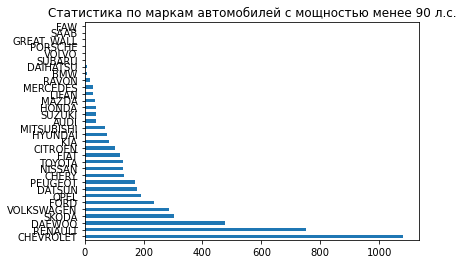

In [57]:
df[(df['Train']==1) & (df['enginePower']<90)]['brand'].value_counts().plot(kind = 'barh', title='Cтатистика по маркам автомобилей с мощностью менее 90 л.с.')

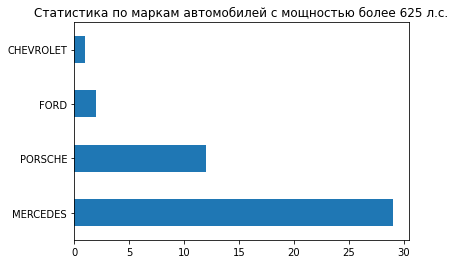

In [58]:
df[(df['Train']==1) & (df['enginePower']>625)]['brand'].value_counts().plot(kind = 'barh', title='Cтатистика по маркам автомобилей с мощностью более 625 л.с.')

Видим что таких значений не много, удалим их для того чтобы уменьшить количесво вывросов данных

In [59]:
df=df[(df['enginePower']<=625) & (df['enginePower']>=90)]

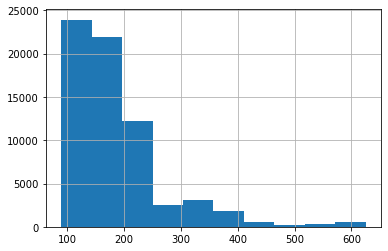

In [60]:
df['enginePower'].hist()

In [61]:
df['enginePower'] = df['enginePower'].astype('int64')

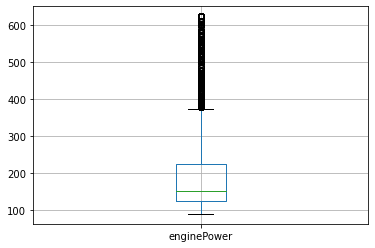

In [62]:
df.boxplot(column='enginePower')

In [63]:
EDA_done_cols.append('enginePower')

Итого обратали признак enginePower и уменьшили количество выбросов.

#### 7.5 numberOfDoors

In [64]:
# изменим тип занчений этого признака на int64
df['numberOfDoors'] = df['numberOfDoors'].astype('int64')

In [65]:
EDA_done_cols.append('numberOfDoors')

В данном признаке больше нет других проблем. Оставим его как есть.

#### 7.6 mileage

In [66]:
# изменим тип данных на int64
df['mileage'] = df['mileage'].astype('int64')

In [67]:
print('Mean:', df['mileage'].mean())
print('Median:', df['mileage'].median())
print('Min:', df['mileage'].min())
print('Max:', df['mileage'].max())

Mean: 114772.70906354315
Median: 105510.5
Min: 0
Max: 1000000


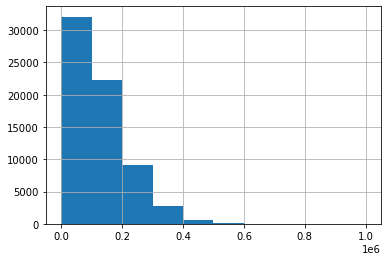

In [68]:
df['mileage'].hist()

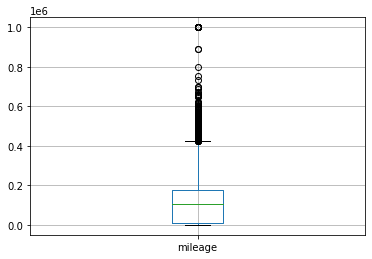

In [69]:
df.boxplot(column='mileage')

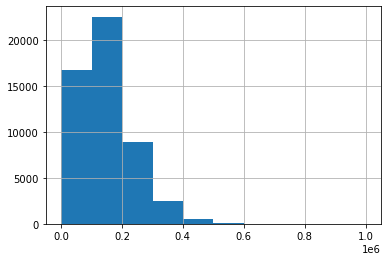

In [70]:
# посмотрим на гистограммы на автомабилях с пробегом
df[df['mileage'] > 1000]['mileage'].hist()

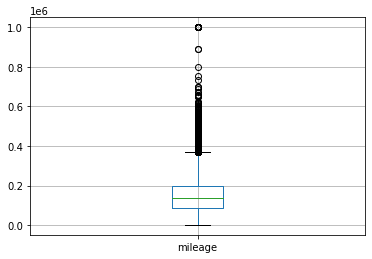

In [71]:
df[df['mileage'] > 1000].boxplot(column='mileage')

fence_low: -258611.25  fence_high: 441246.75
Количество значений за границей: 395


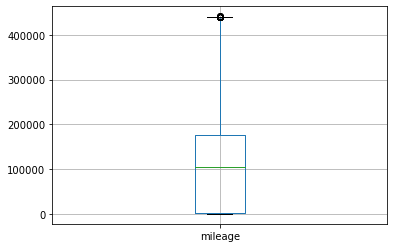

In [72]:
# посмотрим на граници выбросов
q_low = df[df.Train==1]['mileage'].quantile(0.25)
q_high = df[df.Train==1]['mileage'].quantile(0.75)
iqr = q_high - q_low
fence_low = q_low - 1.5*iqr
fence_high = q_high + 1.5*iqr
print('fence_low:', fence_low, ' fence_high:', fence_high)
print('Количество значений за границей:', len(df[df.Train==1]) - len(df[(df.Train==1) & (df['mileage'] > fence_low) & (df['mileage'] < fence_high)]))
df[(df.Train==1) & (df['mileage'] > fence_low) & (df['mileage'] < fence_high)].boxplot(column='mileage')

In [73]:
# посмотрим какие это марки с такими пробегами более 417000
df[(df['Train']==1) & (df['mileage']>417000)].brand.value_counts()

MERCEDES      75
TOYOTA        72
AUDI          64
VOLKSWAGEN    58
BMW           57
NISSAN        34
MITSUBISHI    28
VOLVO         24
FORD          19
OPEL          17
SKODA         13
HYUNDAI       12
SAAB          10
SUBARU        10
PEUGEOT        8
KIA            7
HONDA          7
MAZDA          6
RENAULT        5
LAND_ROVER     4
JEEP           4
CHEVROLET      3
SUZUKI         3
DAEWOO         3
LEXUS          3
CITROEN        2
CHRYSLER       1
DODGE          1
Name: brand, dtype: int64

In [74]:
# проверим то же самое в тесте
df[(df['Train']==0) & (df['mileage']>417000)].brand.value_counts()

BMW    27
Name: brand, dtype: int64

In [75]:
df = df[((df.Train==1) & (df['mileage'] <= 417000)) | (df.Train==0)]

In [76]:
EDA_done_cols.append('mileage')

Итого удалили 556 выбросов с пробегом выше 417000 км. Пропусков нет.

#### 7.7 Владельцы

In [77]:
len(df[df['Владельцы'].isna()])

15428

Видим что этот признак содержит достаточно много значений NaN. Посмотрим на пробег автомобилей у которых этот признак NaN

In [78]:
df[df['Владельцы'].isna()].mileage.unique()

array([0])

Видно что все значения в признаке Владельцы равные NaN это новые автомобили у которых пока ещё нет владельца. Заполним пропуски нулями.

In [79]:
df['Владельцы'].fillna(0, inplace=True)

In [80]:
EDA_done_cols.append('Владельцы')

#### 7.8 price

В этом признаке есть много пропусков. Посмотрим на их количество в трейне

In [81]:
len(df[(df.Train == 1) & (df['price'].isna())])

214

Значений не много, удалим их.

In [82]:
df = df[((df['Train']==1)&(df['price'].isna()==False)) | (df['Train']==0)] 

In [83]:
EDA_done_cols.append('price')

#### 7.9 modelDate

In [84]:
df['modelDate'] = df['modelDate'].astype('int')

In [85]:
df.modelDate.describe()

count    66340.000000
mean      2010.577902
std          7.171502
min       1949.000000
25%       2006.000000
50%       2011.000000
75%       2017.000000
max       2020.000000
Name: modelDate, dtype: float64

In [86]:
df[df.Train == 0].modelDate.describe()

count    3837.000000
mean     2009.948137
std         5.451623
min      1975.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: modelDate, dtype: float64

Видим что в тесте нет данных о моделях 2020 года и о моделях младше 1975 года. Посмотрим количество авто которые находятся за пределами 2019 и 1975 годов.

In [87]:
len(df[(df.modelDate > 2019) | (df.modelDate < 1975)])

2677

Видим что таких автомобилей не так уж и много, удалим их чтобы уменьшить разброс цен.

In [88]:
df = df[((df['Train']==1) & (df['modelDate']>=1975) & (df['modelDate']<=2019)) | (df['Train']==0)]

In [89]:
EDA_done_cols.append('price')

Итого мы удалили 1867 выброса авто старше 1975 года и авто 2020 года.

#### 7.10 productionDate

In [90]:
df['productionDate'] = df['productionDate'].astype('int')

In [91]:
df[df.Train == 1].productionDate.describe()

count    59826.000000
mean      2012.341708
std          6.734625
min       1976.000000
25%       2008.000000
50%       2013.000000
75%       2018.000000
max       2020.000000
Name: productionDate, dtype: float64

In [92]:
df[df.Train == 0].productionDate.describe()

count    3837.000000
mean     2011.934584
std         5.186576
min      1981.000000
25%      2010.000000
50%      2013.000000
75%      2016.000000
max      2019.000000
Name: productionDate, dtype: float64

In [93]:
len(df[(df.Train == 1) & (df.productionDate > 2019)])

12865

Такое количество это нормально так как тестовый датасет формировался в начале года и это значит что в тесте авто с датой производства 2020 нет. Удалим их.
Посмотрим на количество авто с датой производства меньше 1981.

In [94]:
len(df[(df['Train']==1) & (df['productionDate']<1981)])

15

In [95]:
# Удалим выбросы по порогу
df = df[((df['Train']==1) & (df['productionDate']>=1981) & (df['productionDate']<=2019)) | (df['Train']==0)]

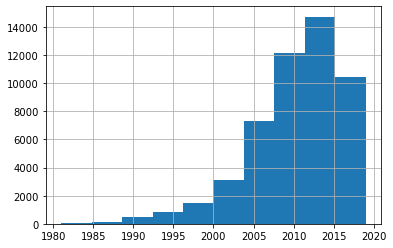

In [96]:
df['productionDate'].hist()

In [97]:
# Добавим два новый признака: 'km_per_year' который равен пробегу авто поделённому на его возраст
current_year = 2020
df['km_per_year'] = df['mileage'] / (current_year-df['productionDate'])

Было бы не плохо добавить категориальный признак который мог бы определить авто в один из 4 классов: новый, относительно новые, относительно старые, старые. Для этого посмотрим как меняется стоимость на авто в зависимотси от года выпуска на примере марки BMW

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


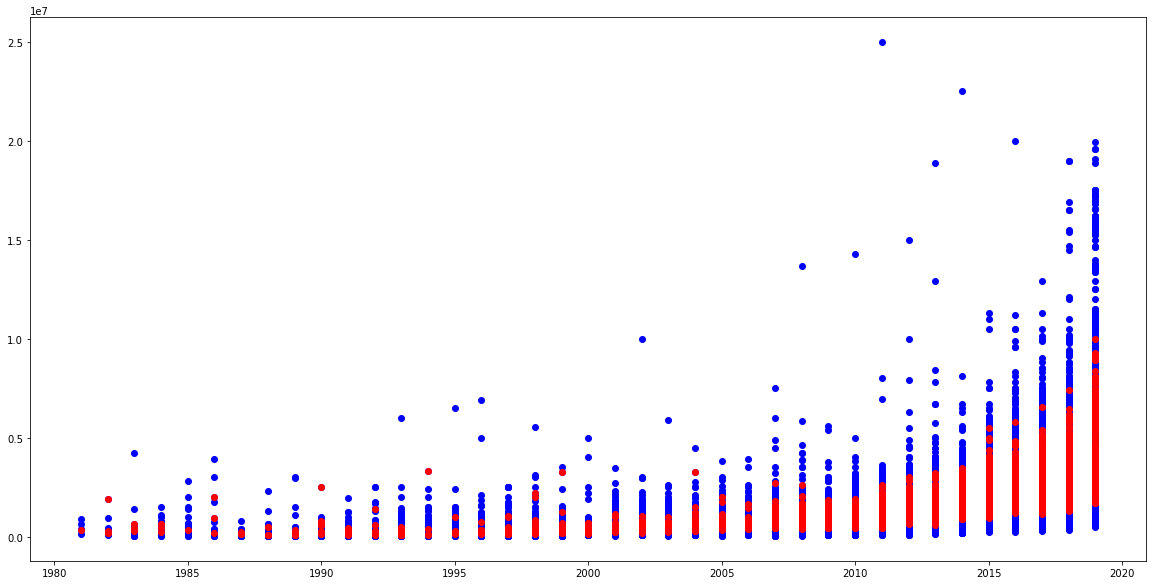

In [98]:
df_temp = df[(df['Train']==1)&(df['productionDate']<2020)]
df_temp_bmw = df_temp[df['brand']=='BMW']
year = df_temp['productionDate'].values
price = df_temp['price'].values
year_bmw = df_temp_bmw['productionDate'].values
price_bmw = df_temp_bmw['price'].values
plt.figure(figsize=(20,10))
plt.scatter(year,price,c='b')
plt.scatter(year_bmw,price_bmw,c='r')

Видим что за первые 5 лет стоимость авто падает очень быстро, это связано с рыночной ситуацией так как после покупки у новых авто гарантийный период длится в пределах от 3 до 5 лет, дальше видим что цена падает не так сильно в периоде от 2015 до 2005 года. Далее наблюдаем относительное удержание цены на примерно одном уровне в периоде с 1990 до 2005, после 1990 цена на авто падает. Добавим новый категориальный признак в котором разделим авто на 4 класса: младше 2015, с 2005 до 2015, с 1990 до 2005, старше 1990.

In [99]:
df['pDate_more_2015']=df['productionDate']>=2015
df['pDate_more_2005']=(df['productionDate']>=2005)&(df['productionDate']<2015)
df['pDate_more_1990']=(df['productionDate']>=1990)&(df['productionDate']<2005)
df['pDate_less_1990']=(df['productionDate']<1990)

In [100]:
EDA_done_cols.append('productionDate')

#### 7.11 vehicleTransmission

In [101]:
df[df['Train']==1]['vehicleTransmission'].value_counts()

автоматическая      26557
механическая        12632
роботизированная     4222
вариатор             3535
Name: vehicleTransmission, dtype: int64

In [102]:
df[df['Train']==0]['vehicleTransmission'].value_counts()

автоматическая      3677
механическая         111
роботизированная      49
Name: vehicleTransmission, dtype: int64

In [103]:
# удалим вариатор
df = df[((df['Train']==1) & (df['vehicleTransmission']!='вариатор')) | (df['Train']==0)]

In [104]:
EDA_done_cols.append('vehicleTransmission')

Итого удалили из признака значения равные "вариатор" так как их нет а тесте. Пропусков нет.

#### 7.12 Комплектация

В этом признаке было много не заполненных значений равных "{id:0}". Посмотрим что изменилось

In [105]:
temp_df = df[df['Train']==1]
(temp_df['Комплектация']=={'id': '0'}).sum()/len(temp_df)

0.7954896224459238

Почти 80% данных не заполнены, удаляем это признак.

In [106]:
df.drop(columns=['Комплектация'], inplace=True)

#### 7.13 description

Данный признак содержит описание авто владельцем. Достаточно трудный для анализа признак так как содержит много текстовой информации. Заполним пропуски 0 и выделим новый признак который подсчитает количество слова в тексте каждого объявления.

In [107]:
# заполним пропуски
df['description'] = df['description'].fillna('[]')

In [108]:
# запишем списки слов в описании в отдельный столбец
df['words_in_description'] = df['description'].apply(lambda x: [str(i).lower() for i in x.split()])

In [109]:
# создаем новый признак кол-во слов в описании
df['count_words_d'] = df['description'].apply(lambda x: len(x.split()))

In [110]:
EDA_done_cols.append('description')

Итого заполнили пропуски и добавили новый признак words_in_description

#### 7.14 ПТС

In [111]:
# Посмотрим на количество пропусков
len(df[(df.Train == 1) & (df['ПТС'].isna())])

12

Всего 14 пропусков. Эти пропуски относятся к новым автомобилям у которых ещё нет владельцев. Удалим эти авто.

In [112]:
df.dropna(subset=['ПТС'], inplace=True)

In [113]:
EDA_done_cols.append('ПТС')

#### 7.15 Владение

In [114]:
# Посмотрим на колчество пропусков в этом признаке
temp_df = df[df['Train']==1]
len(temp_df[temp_df['Владение'].isna()])/len(temp_df)

0.679762206502454

Видим что 68% данных в этом признаке это пропуски, удалим его.

In [115]:
df.drop(columns=['Владение'], inplace=True)

#### 7.16 model

Этого признака нет а тестовом наборе данных, поэтому удаляем его

In [116]:
df.drop(columns=['model'], inplace=True)

#### Итог EDA:
    - были обработаны все данные и приведены к доступному для дальнейшей работы формату
    - удалены пропуски
    - добавлены новые признаки

In [117]:
df.to_csv('EDA_analised_auto_ru_data.csv', index=False)

In [118]:
df = pd.read_csv('EDA_analised_auto_ru_data.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 8 Перекрёстный анализ между переменными и целевой переменной price

In [119]:
import seaborn as sns

In [120]:
corrMatrix = df.corr()

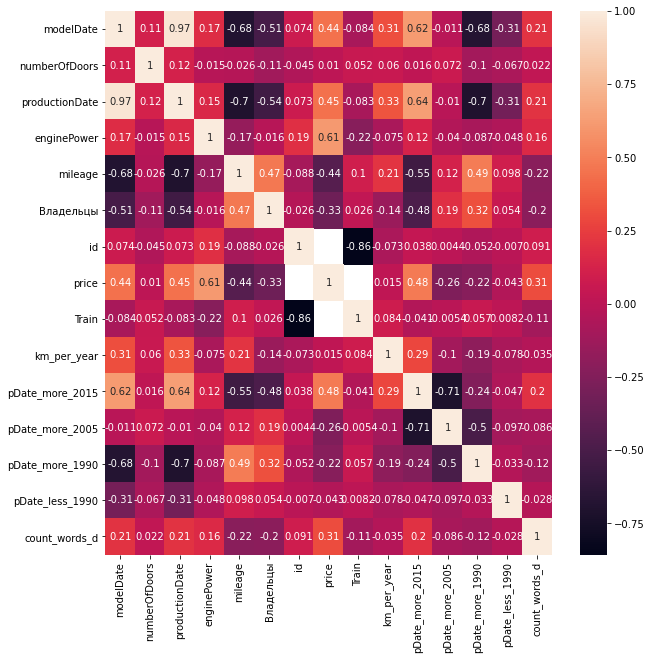

In [121]:
plt.figure(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

Видим что большая корреляция наблюдается между двумя признаками modelDate и productionDate, остальные признаки скоррелированы не так сильно. На данном этапе не будем принимать решение какой из столбцов modelDate или productionDate удалять.

### 9 Добавление новых признаков

In [122]:
df['Руль_num'] = 0
for i in range(1, len(df['Руль'].unique())+1):
    df.loc[df[df['Руль'] == df['Руль'].unique()[i-1]].index, 'Руль_num'] = i

In [123]:
# признак Таможня содержит одинаковые значения, удалим его
df['Таможня'].unique()

array([True, 'True', 'Растаможен'], dtype=object)

In [124]:
df.drop(columns=['Таможня'], inplace=True)

In [125]:
df.drop(columns=['description'], inplace=True)

In [126]:
df.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'enginePower', 'mileage',
       'Привод', 'Руль', 'Владельцы', 'ПТС', 'id', 'price', 'Train',
       'km_per_year', 'pDate_more_2015', 'pDate_more_2005', 'pDate_more_1990',
       'pDate_less_1990', 'words_in_description', 'count_words_d', 'Руль_num'],
      dtype='object')

In [127]:
df['price'] = df['price'].apply(lambda x: np.log(x))

In [128]:
df = pd.get_dummies(df, columns = ['bodyType', 'color', 'fuelType', 'vehicleTransmission', 'Привод', 'ПТС'], dummy_na=False)

In [129]:
X_train = df[df.Train==1]
X_sub = df[df.Train==0]

### 10 Подготовка датасета для машинного обучения

In [130]:
from sklearn.model_selection import train_test_split

In [131]:
X = X_train.drop(columns=['brand', 'id', 'Train', 'words_in_description', 'Руль', 'price'])
y = X_train['price'].values

In [132]:
X_test = X_sub.drop(columns=['brand', 'id', 'price', 'Train', 'Руль', 'words_in_description']) 

In [133]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X, y, test_size=0.3)

### 11 Single model

In [134]:
from sklearn.ensemble import RandomForestRegressor

In [135]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [136]:
RANDOM_SEED = 42
ITERATIONS = 5000

In [137]:
model = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)

In [138]:
model.fit(X_train_split, y_train_split)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.7s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [139]:
print(mape(y_val_split, model.predict(X_val_split)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


1.1881726587603503


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [140]:
import pickle

In [141]:
filename = 'RandomForestRegressor_single_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [142]:
predict_submission = model.predict(X_test)
sample_submission['price'] = predict_submission
sample_submission['price'] = sample_submission['price'].apply(lambda x: np.exp(x))
sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x/1000)*1000)
sample_submission.to_csv(f'catboost_submission_v3.csv', index=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [143]:
sample_submission.head()

,id,price
0,0,2074000
1,1,2988000
2,2,1556000
3,3,3129000
4,4,5730000


### Fit&Submit Stacking

In [144]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from tqdm.notebook import tqdm

In [145]:
models = [RandomForestRegressor(n_estimators =250,random_state = RANDOM_SEED, n_jobs = -1, verbose = 1),
         BaggingRegressor(ExtraTreeRegressor(random_state=RANDOM_SEED), random_state=RANDOM_SEED)]

def stacking_model_predict(models, X, y, X_sub, sample_submission):
    for model_ in tqdm(models):
        model_.fit(X, y)
        pred_subm = model_.predict(X_sub)
        
        sample_submission[str(model_)[:6]] = pred_subm
        sample_submission[str(model_)[:6]] = sample_submission[str(model_)[:6]].apply(lambda x: np.exp(x) )
        sample_submission[str(model_)[:6]] = sample_submission[str(model_)[:6]].apply(lambda x: round(x/1000)*1000)
    
    sample_submission['price'] = sample_submission.iloc[:,2:].mean(axis=1)
    sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x/1000)*1000)
    sample_submission[['id', 'price']].to_csv(f'submission_stack_v3.csv', index=False)

stacking_model_predict(models, X_train_split, y_train_split, X_test, sample_submission)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   25.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


In [146]:
sample_submission.head()

,id,price,Random,Baggin
0,0,2131000,2066000,2196000
1,1,2864000,2906000,2823000
2,2,1548000,1556000,1540000
3,3,3193000,3130000,3256000
4,4,6384000,5722000,7045000
